In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deep_hedging import (
    Underlyings,
    Ticker,
    ConstantRateCurve,
    EuropeanCall,
)
from deep_hedging.hedger import HedgeSimulator
from deep_hedging.monte_carlo import GBMSimulator, CorrelatedHestonSimulator
from deep_hedging.monte_carlo.bid_ask import WhiteNoiseBidAskSimulator
from deep_hedging.monte_carlo.volatility import VasicekVolatilitySimulator
from deep_hedging.monte_carlo.rates import VasicekSimulator

RANDOM_SEED = 12

In [3]:
N_PATHS = 10_000

N_STOCKS = 1
TILL_MATURITY = 3.0
TRADING_DAYS = 252
N_DAYS = TRADING_DAYS * TILL_MATURITY

VOL = 0.2

RF_RATE = 0.03
RATES_VOL = 0.0
# RATES_VOL = 0.01

# BID_ASK = 0.05 / 100
BID_ASK = 0.0

In [4]:
np.random.seed(RANDOM_SEED)

start = dt.datetime(2019, 1, 1)
end = start + dt.timedelta(days=N_DAYS)

random_returns = np.concatenate(
    [
        np.expand_dims(np.array([1.0]), 1),
        np.exp(
            (RF_RATE - VOL**2 / 2) / TRADING_DAYS
            + VOL / np.sqrt(TRADING_DAYS) * np.random.randn((end - start).days, N_STOCKS)
        ),
    ],
    axis=0,
)
data = pd.DataFrame(
    random_returns,
    columns=["close"],
)
data["close"] = data["close"].cumprod()
data["index"] = pd.date_range(start=start, end=end, freq="1D")
data.set_index("index", inplace=True)

underlyings = Underlyings(
    tickers=[Ticker(f"Stock {i + 1}", f"{i + 1}") for i in range(N_STOCKS)],
    start=start,
    end=end,
    data=data,
    dividends=np.array([0.0] * N_STOCKS),
)
underlyings.data

,close
index,
2019-01-01,1.000000
2019-01-02,1.006017
2019-01-03,0.997457
2019-01-04,1.000548
2019-01-05,0.979375
...,...
2021-01-22,0.714950
2021-01-23,0.723401
2021-01-24,0.718739


In [5]:
np.random.seed(RANDOM_SEED + RANDOM_SEED)

start = dt.datetime(2019, 1, 1)
end = start + dt.timedelta(days=N_DAYS)

random_returns = np.concatenate(
    [
        np.expand_dims(np.array([RF_RATE]), 1),
        RATES_VOL / np.sqrt(TRADING_DAYS) * np.random.randn((end - start).days, N_STOCKS),
    ],
    axis=0,
)
rates = pd.DataFrame(
    random_returns,
    columns=["close"],
)
rates["close"] = rates["close"].cumsum()
rates["index"] = pd.date_range(start=start, end=end, freq="1D")
rates.set_index("index", inplace=True)
rates

,close
index,
2019-01-01,0.03
2019-01-02,0.03
2019-01-03,0.03
2019-01-04,0.03
2019-01-05,0.03
...,...
2021-01-22,0.03
2021-01-23,0.03
2021-01-24,0.03


In [6]:
curve = ConstantRateCurve(constant_rate=RF_RATE)

In [7]:
european_call = EuropeanCall(
    underlyings=underlyings,
    yield_curve=curve,
    strike_level=1.0,
    start_date=start,
    end_date=end,
)

In [8]:
volatility_simulator=VasicekVolatilitySimulator(
    random_seed=RANDOM_SEED,
)
volatility_simulator.fit(underlyings.data)

rates_simulator=VasicekSimulator(
    random_seed=RANDOM_SEED,
)
rates_simulator.fit(rates)

bid_ask_simulator=WhiteNoiseBidAskSimulator(
    random_seed=RANDOM_SEED,
)

In [9]:
rates_simulator.simulate(
    r0=RF_RATE,
    terms=np.arange(1, 100),
    n_paths=100
)

array([[0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
       ...,
       [0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03]])

In [10]:
corr_matrix = np.identity(2 * N_STOCKS + 2)
corr_matrix

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [11]:
volatility_simulator.sigma

0.00559340484254123

In [12]:
gbm_simulator = GBMSimulator(payoff_function=european_call.payoff, random_seed=RANDOM_SEED)

heston_simulator = CorrelatedHestonSimulator(
    volatility_simulator=volatility_simulator,
    rates_simulator=rates_simulator,
    bid_ask_simulator=bid_ask_simulator,
    payoff_function=european_call.payoff,
    random_seed=RANDOM_SEED,
)

In [13]:
%%time
gbm_paths = gbm_simulator.get_paths(
    spot=[1.0],
    time_till_maturity=TILL_MATURITY,
    risk_free_rate_fn=curve.get_instant_fwd_rate,
    dividends_fn=lambda t: 0.0,
    var_covar_fn=lambda t: np.array([VOL**2] * len(t)),
    n_paths=N_PATHS,
)
gbm_paths.shape

CPU times: user 227 ms, sys: 43.4 ms, total: 270 ms
Wall time: 292 ms


(10000, 757, 1)

In [14]:
%%time
bids, asks, rates = heston_simulator.get_paths(
    spot=[1.0],
    bid_ask_spread=[BID_ASK],
    rf_rate=RF_RATE,
    vol_start=[VOL],
    bid_ask_spread_var_covar_fn=lambda t: np.array([0] * len(t)),
    time_till_maturity=TILL_MATURITY,
    risk_free_rate_fn=curve.get_instant_fwd_rate,
    dividends_fn=lambda t: 0.0,
    corr_fn=lambda t: np.array([corr_matrix] * len(t)),
    n_paths=N_PATHS,
)
bids.shape, asks.shape, rates.shape

CPU times: user 15.7 s, sys: 438 ms, total: 16.2 s
Wall time: 16.5 s


((10000, 757, 1), (10000, 757, 1), (10000, 756))

In [15]:
hedger = HedgeSimulator(european_call, look_ahead=True)

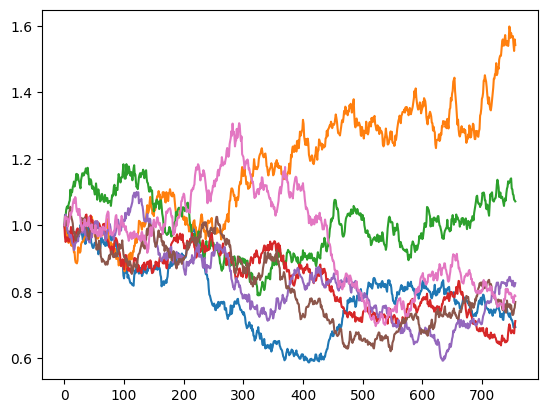

In [16]:
days = np.arange(N_DAYS + 1)
plt.plot(days, gbm_paths[3:10, :].squeeze(2).T, label="GBM")
plt.show()

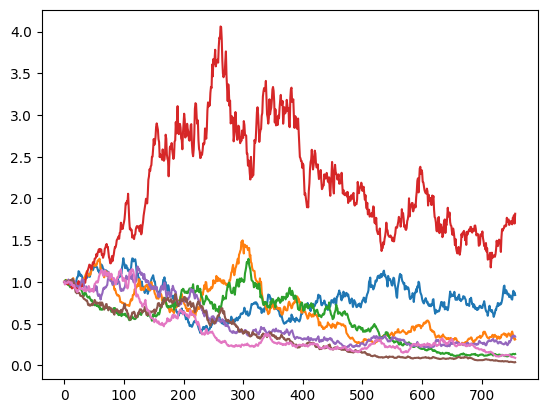

In [17]:
plt.plot(days, bids[3:10, :].squeeze(2).T, label="Heston")
plt.show()

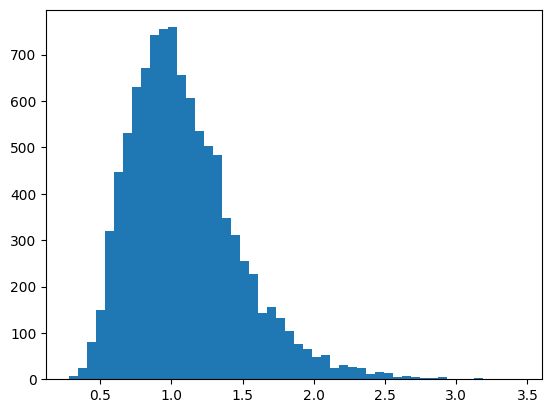

In [18]:
plt.hist(gbm_paths[:, -1].squeeze(1).T, bins=50)
plt.show()

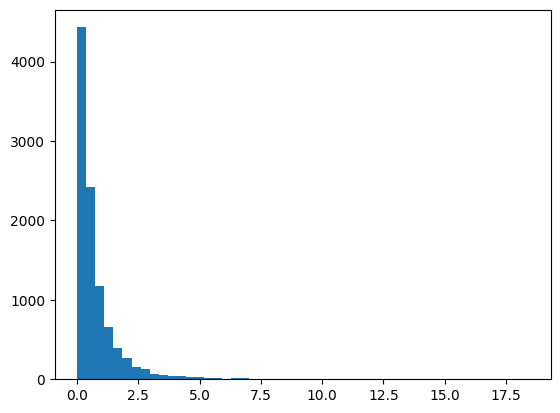

In [19]:
plt.hist(bids[:, -1].squeeze(1).T, bins=50)
plt.show()

In [20]:
gbm_final_point = gbm_paths[:, -1].squeeze(1).T
gbm_returns = np.log(gbm_final_point / np.roll(gbm_final_point, 1))
gbm_returns.mean(), gbm_returns.std()

(-1.1435297153639113e-18, 0.4866498957945286)

In [21]:
heston_final_point = bids[:, -1].squeeze(1).T
heston_returns = np.log(heston_final_point / np.roll(heston_final_point, 1))
heston_returns.mean(), heston_returns.std()

(-3.375077994860476e-18, 1.548759080241562)

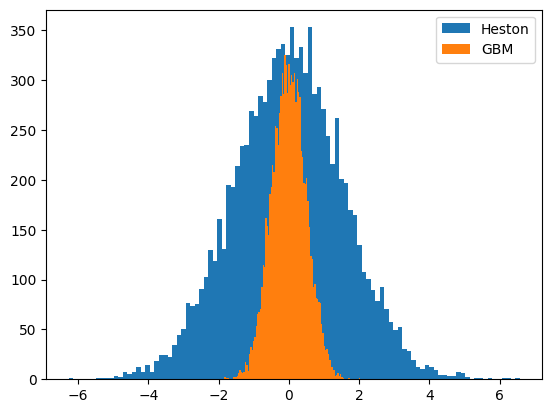

In [22]:
plt.hist(heston_returns, bins=100, label="Heston")
plt.hist(gbm_returns, bins=100, label="GBM")
plt.legend()
plt.show()

In [23]:
bids[:, -1]

array([[1.02033153],
       [0.68585417],
       [1.25646445],
       ...,
       [0.13814998],
       [0.08660233],
       [0.73329982]])

### Only spot.

In [24]:
simulated_price = hedger.price(
    bids=bids.squeeze(2),
    asks=asks.squeeze(2),
    rates_lend=curve(european_call.days_till_maturity) / TRADING_DAYS,
    rates_borrow=curve(european_call.days_till_maturity) / TRADING_DAYS,
)
simulated_price, european_call.price().item()

(0.4461915030237631, 0.14427105390300576)

### Spot and rates.

In [25]:
simulated_price = hedger.price(
    bids=bids.squeeze(2),
    asks=asks.squeeze(2),
    rates_lend=rates / TRADING_DAYS,
    rates_borrow=rates / TRADING_DAYS,
)
simulated_price, european_call.price().item()

(0.4461915030237631, 0.14427105390300576)

### To model:
* interest rate by HWM
* bid-offer spread, correlated with vol of 
* (Adv.) interest rate, correlated to Sber
* HestonSimulator
* Fit Heston into market via volatility simile using pytorch optimization
* hedging frequency
* LSTMHedger
* bid-offer spread estimate = short option premium from implied vol of option under consideration.